***DATASET : https://www.kaggle.com/datasets/moltean/fruits***

<div class = 'h4'> what's new in this notebook </div>
<div class = 'h3'> 
<div class = 'h1'> 1. using weight decay instead of reducing the number of weights :</div> 
 as many of people used to do , they tend to reduce the number of weights in neural network in order to make it more simple and prevent overfitting , but this is in fact a very limiting strategy , since more parametres means more interactions hence more non linearities , wich really helps in detecting patterns for highly complex problems  , so what about overfitting !
well to reduce the variance (prevent overfitting) , (and also exploding gradient problem)  we can use weight decay wich penelizes the model's complexity without decreasing the number of parametres , it works by adding a penalty term to the cost function of a neural network which has the effect of shrinking the weights during backpropagation . 
to have a better idea please check this great article 

    
    https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab
    
  
    
    
    
    

    
    
    


In [1]:
! install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

install: missing destination file operand after 'kaggle'
Try 'install --help' for more information.


In [2]:
!kaggle datasets download -d moltean/fruits

 99% 1.28G/1.28G [00:06<00:00, 217MB/s]
100% 1.28G/1.28G [00:06<00:00, 214MB/s]


In [ ]:
! unzip fruits.zip

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.datasets import load_files
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import np_utils


Text(0.5, 1.0, 'cocos')

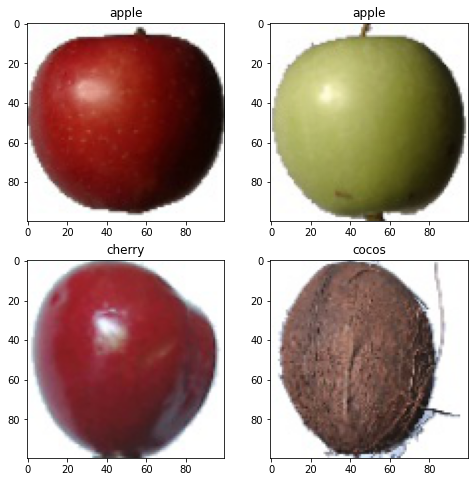

In [8]:
from PIL import Image
import os
#storing each sample to a variable in order to visualize it 
sample1 = Image.open('/content/fruits-360_dataset/fruits-360/Training/Apple Braeburn/100_100.jpg')
sample2 = Image.open('/content/fruits-360_dataset/fruits-360/Training/Apple Granny Smith/113_100.jpg')
sample3 = Image.open('/content/fruits-360_dataset/fruits-360/Training/Cherry 2/107_100.jpg')
sample4 = Image.open('/content/fruits-360_dataset/fruits-360/Training/Cocos/103_100.jpg')


fig = plt.figure(figsize = (8,8))
a1 = fig.add_subplot(2,2,1)
img_plot = plt.imshow(sample1)
a1.set_title('apple')

a2 = fig.add_subplot(2, 2, 2)
img_plot = plt.imshow(sample2)
a2.set_title('apple')

a3 = fig.add_subplot(2, 2, 3)
img_plot = plt.imshow(sample3)
a3.set_title('cherry')

a4 = fig.add_subplot(2, 2, 4)
img_plot = plt.imshow(sample4)
a4.set_title('cocos')


In [9]:
import os, os.path
l1 = []
L2 = []
a = '/content/fruits-360_dataset/fruits-360/'
train_categories = os.listdir(a + 'Training') #storing the path of training folders
test = os.listdir(a + 'Test') #storing the path of testing folders

for i in os.listdir(a + "Training/"):
    l1.append(len(os.listdir(a + "Training/"+ i)))#iterating over the training folder 
    #then add the lengh of the category 'i' of each iteration 
    
for i in os.listdir(a + "Test/"):
    L2.append(len(os.listdir(a + "Test/"+ i)))

In [10]:
print("Number of Fruits in Training set:", np.sum(l1))#summing the list that contains 
#the number of folders for each category
print("Number of Fruits in test set:", np.sum(L2))

Number of Fruits in Training set: 67692
Number of Fruits in test set: 22688


# <div class = 'h1'> The barplot:</div> 

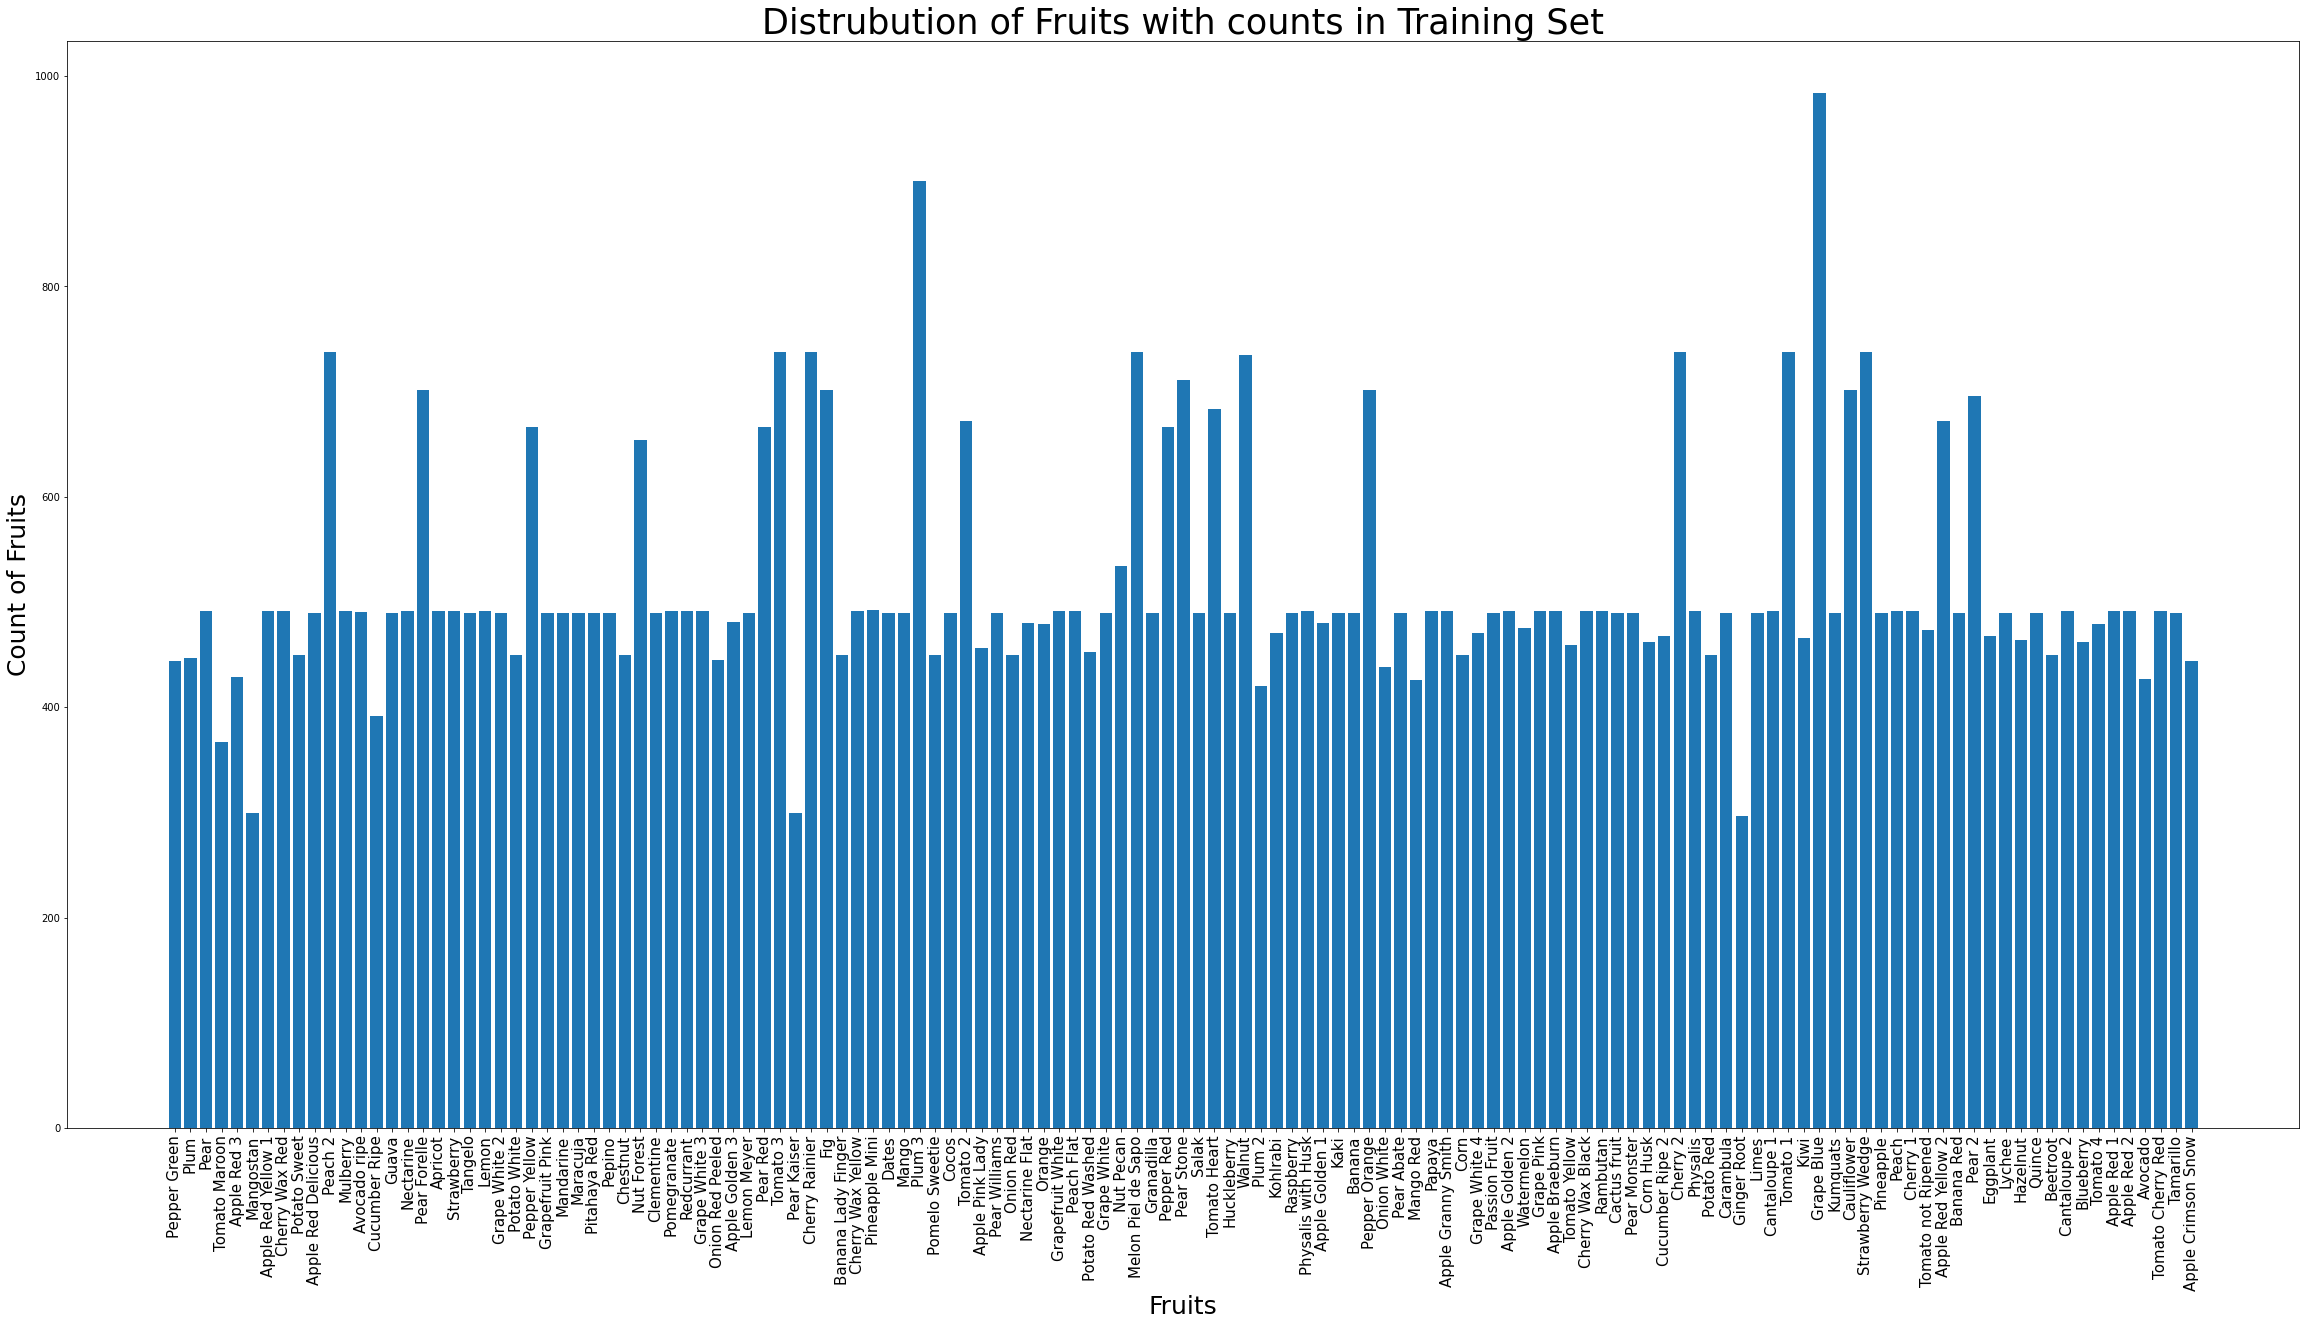

In [11]:
figure_size = plt.rcParams["figure.figsize"]#altering the default parametres of plt
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size
index = np.arange(len(train_categories))
plt.bar(index, l1)
plt.xlabel('Fruits', fontsize=25)
plt.ylabel('Count of Fruits', fontsize=25)
plt.xticks(index, train_categories, fontsize=15, rotation=90)
plt.title('Distrubution of Fruits with counts in Training Set', fontsize=35)
plt.show()

the data is somehow unbalanced for some categories but it's ok since 80% of data are of the same length

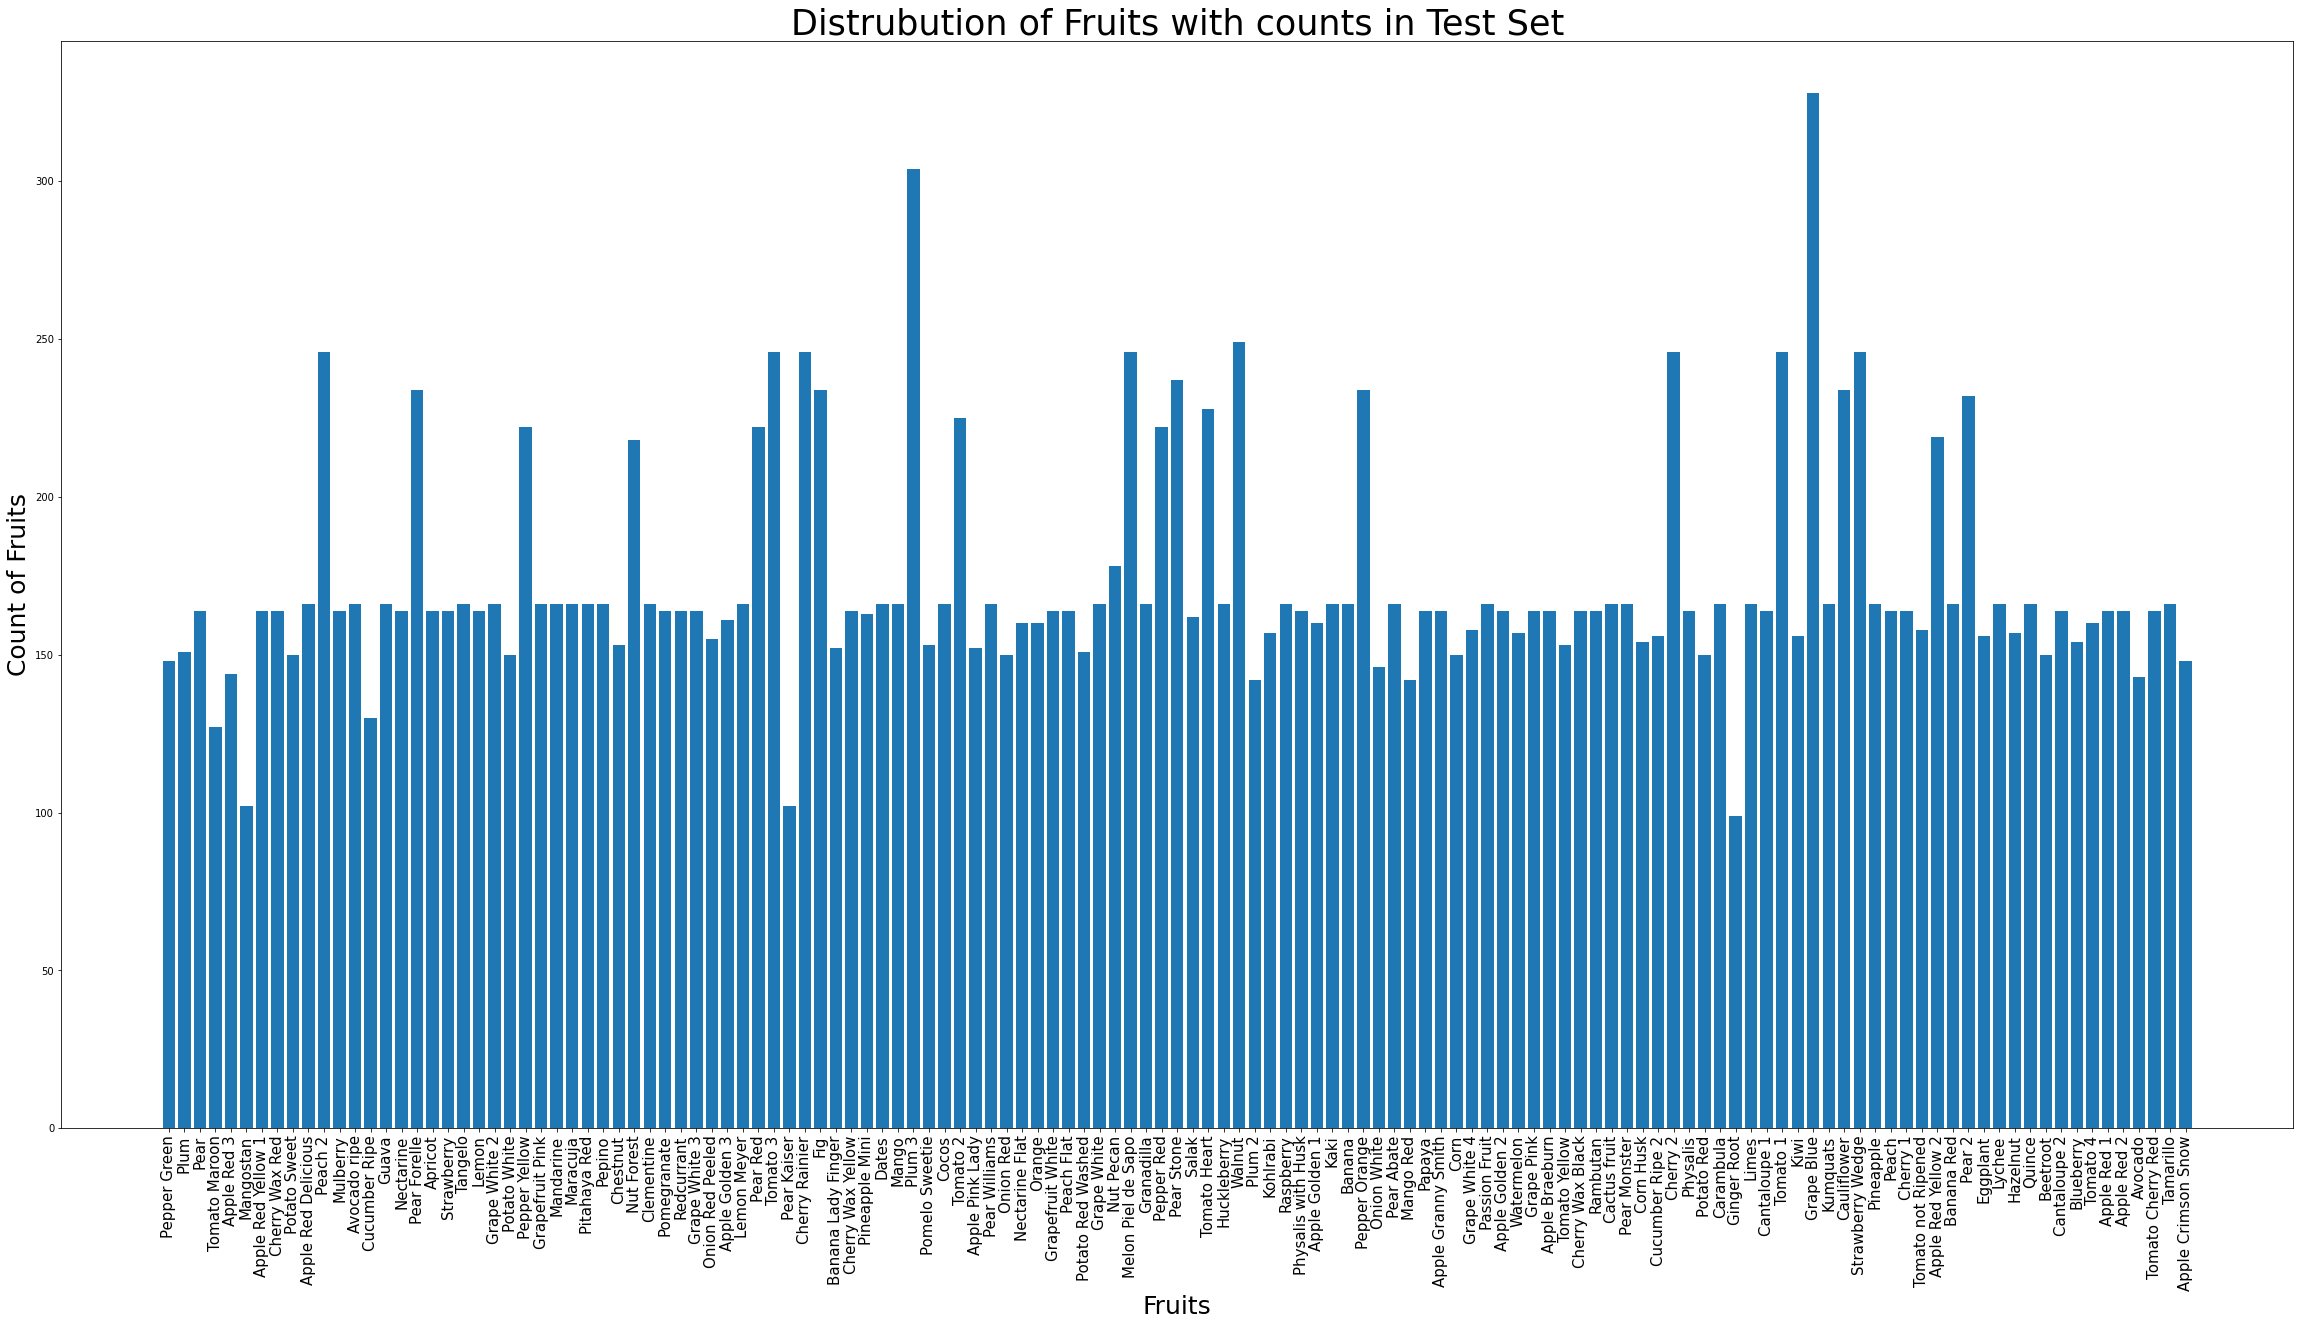

In [12]:
index2 = np.arange(len(test))
plt.bar(index, L2)
plt.xlabel('Fruits', fontsize=25)
plt.ylabel('Count of Fruits', fontsize=25)
plt.xticks(index2, test, fontsize=15, rotation=90)
plt.title('Distrubution of Fruits with counts in Test Set', fontsize=35)
plt.show()

<div class = 'h2'> Data loading : </div>

<div class = 'h3'> Here i've used only 15 categories from the available ones , due to the limited memory of kaggle's notebook .</div>

In [13]:
import cv2

np.random.seed(1234)
directory_train =  a + "Training/" 
classes = ['Quince',
 'Grapefruit White',
 'Granadilla',
 'Orange',
 'Apple Red 3',
 'Grape White 2',
 'Corn Husk',
 'Tamarillo',
 'Banana Red',
 'Nectarine Flat',
 'Pepper Yellow',
 'Nut Forest',
 'Pear Monster',
 'Fig',
 'Tomato Heart']

directory_test =  a + "Test/"


In [15]:
img_size = 200
def df(classes , directory):
    full_df = []
    for i in classes:
        path = os.path.join(directory,i)#storing the path of the category 
        class_index = classes.index(i)#storing the label (the category)
        for img in os.listdir(path):#iterating over the images of the current (the i'th) category
            img_array = cv2.imread(os.path.join(path,img))#reading the image 
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)#converting the image to RGB 
            #because openCV represent the images in BGR order contraty to other libraries
            full_df.append([img_array,class_index])#append the image array with its label 
    return full_df

In [16]:
train_df = df(classes , directory_train)
test_df = df(classes , directory_test)

In [17]:
import random 
random.shuffle(train_df)

x_train = []
y_train = []
for features,label in train_df:
    x_train.append(features) #storing the features (images arrays into the x_train list )
    y_train.append(label)
x_train = np.array(x_train) #cnoverting the list to an np array 

In [18]:
import random  #same to what we did previously 
random.shuffle(test_df)

x_test = []
y_test = []
for features,label in test_df:
    x_test.append(features)
    y_test.append(label)
x_test = np.array(x_test) 

In [19]:
len(y_test)

2680

In [20]:
y_train = np_utils.to_categorical(y_train , 15)#one hot encoding the labels  
#the output will be 14 zeros with one value = 1 situated in the specific index of the category 
#for example for orange we will have 000100000000000
y_test = np_utils.to_categorical(y_test , 15)

In [21]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((7988, 100, 100, 3), (2680, 100, 100, 3), (7988, 15), (2680, 15))

In [22]:
from sklearn.model_selection import  train_test_split
#splitting the x train to an x train and x val in order to be able to evaluting the model 
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2 ,random_state = 42)

In [23]:
x_train.shape , y_train.shape , x_val.shape , y_val.shape 

((6390, 100, 100, 3), (6390, 15), (1598, 100, 100, 3), (1598, 15))

In [24]:
x_test.shape , y_test.shape

((2680, 100, 100, 3), (2680, 15))

In [25]:
#normalizing our arrays 
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

In [26]:
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

cnn = Sequential()
cnn.add(Conv2D(filters = 4 ,kernel_size = (3,3),padding="Same",activation = "relu",input_shape = (100,100,3)))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 8 ,kernel_size = (3,3),padding="Same",activation = "relu"))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 16 ,kernel_size = (3,3),padding="Same",activation = "relu"))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 32 ,kernel_size = (3,3),padding="Same",activation = "relu"))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size = (2,2)))
cnn.add(Flatten())

cnn.add(Dense(400 , kernel_regularizer=l2(0.1) , activation = "relu"))
cnn.add(Dropout(0.))
cnn.add(Dense(50 , kernel_regularizer=l2(0.3) , activation = "relu"))


cnn.add(Dense(15,activation="sigmoid"))
#defining optimizer

#compile the cnn
cnn.compile(optimizer = 'ADAM',loss="categorical_crossentropy",metrics=["accuracy"])
#note : we use categorical cross entropy when the classes are one hot encoded
#otherwise if they were numerical we should use sparse cross entropy

In [27]:
datagen = ImageDataGenerator(
                           featurewise_std_normalization = False, #divide input datas to std
                           samplewise_std_normalization = False,  #divide each datas to own std
                           zca_whitening = False,  #dimension reduction
                           rotation_range = 0.3,    #rotate 5 degree
                           fill_mode='nearest', #to fill the empty pixels after rotation
                           zoom_range = 0.2,        #zoom in-out 5%
                           width_shift_range = 0.2, #shift 5%
                           height_shift_range = 0.2,
                           horizontal_flip = True,  #randomly flip images
                           vertical_flip = True,
                           )



#model fitting


In [28]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss' ,verbose = True , patience = 3 , restore_best_weights = True)

In [30]:
cnn.fit(datagen.flow(x_train,y_train,batch_size = 50 ),epochs = 30,
                            validation_data = (x_val,y_val),steps_per_epoch = x_train.shape[0]//50
                            ,callbacks=[callback] )

Epoch 1/30
127/127 [==============================] - 62s 485ms/step - loss: 7.2466 - accuracy: 0.6899 - val_loss: 3.7724 - val_accuracy: 0.0569
Epoch 2/30
127/127 [==============================] - 60s 472ms/step - loss: 1.3577 - accuracy: 0.7741 - val_loss: 3.4807 - val_accuracy: 0.1370
Epoch 3/30
127/127 [==============================] - 60s 475ms/step - loss: 1.0730 - accuracy: 0.8549 - val_loss: 2.4222 - val_accuracy: 0.4675
Epoch 4/30
127/127 [==============================] - 61s 482ms/step - loss: 0.9600 - accuracy: 0.8770 - val_loss: 1.1914 - val_accuracy: 0.7991
Epoch 5/30
127/127 [==============================] - 60s 475ms/step - loss: 0.7981 - accuracy: 0.9320 - val_loss: 0.6668 - val_accuracy: 0.9844
Epoch 6/30
127/127 [==============================] - 60s 474ms/step - loss: 0.7259 - accuracy: 0.9374 - val_loss: 0.5664 - val_accuracy: 0.9975
Epoch 7/30
127/127 [==============================] - 61s 476ms/step - loss: 0.6663 - accuracy: 0.9429 - val_loss: 0.5066 - val_ac

In [31]:
from keras.preprocessing.image import ImageDataGenerator, load_img
test_datagen = ImageDataGenerator()  #Image normalization.
test_set = test_datagen.flow(x_test , y_test , 
                            batch_size = 100)

In [33]:
cnn.evaluate(test_set , steps = 2 * x_test.shape[0]//100)

27/53 [==============>...............] - ETA: 7s - loss: 0.3072 - accuracy: 0.9567

53/53 [==============================] - 8s 142ms/step - loss: 0.3072 - accuracy: 0.9567


[0.3071790337562561, 0.9567164182662964]

In [34]:
preds = cnn.predict(x_test)
preds = np.argmax(preds, axis=-1)

preds[:10]

array([ 0,  7, 14,  9, 12,  4, 13,  8,  4,  3])

In [35]:
true = np.argmax(y_test, axis=-1)
true[:10]

array([ 0,  7, 14,  9, 12,  4, 13,  8,  4,  3])